## Fit & Validate A Gradient Boosted Classifier and Generate Related Visualizations

In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc, roc_curve

In [13]:
df = pd.read_csv("../data/df_mvp.csv")

In [14]:
# Split the response variable from the predictors
X = df.drop(['label','time_bin','source'],axis=1)
y = df.label

# Split the training from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Within the training data, define validation sets:
X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
# Initialize our classifier
xgb_model = xgb.XGBClassifier()

# brute force scan for all parameters, credits to 
# https://www.kaggle.com/phunter/xgboost-with-gridsearchcv
# Details: 
# usually max_depth is 6,7,8
# learning rate is around 0.05, but small changes may make a big difference
# tuning min_child_weight, subsample, and colsample_bytree can have 
# much importance in avoiding overfitting
# n_estimators is how many rounds of boosting
# finally, ensemble xgboost with multiple seeds may reduce variance. 

param_grid={'colsample_bytree': [0.6, 0.7, 0.8], 'learning_rate': [0.046, 0.048, 0.05, 0.052, 0.054],
                         'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [10, 11, 12],
                         'missing': [-999], 'n_estimators': [1000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'silent': [1], 'subsample': [0.6, 0.8]}

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Initialize and train our classifier

# Fit our classifier
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train, y_train, 
        eval_set=[(X_val_train, y_val_train), (X_val, y_val)],
        eval_metric='logloss',
        verbose = False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=N...
                                     verbosity=None),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [6], 'min_child_weight': [11],
                         'missing': [-999], 'n_estimators': [1000],
                         'nthread': [4], 'o

In [22]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

In [23]:
# make prediction
y_score = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,-1]

accuracy = accuracy_score(y_test, y_score)
precision = precision_score(y_test, y_score)
recall = recall_score(y_test, y_score)
false_pos, true_pos, _ = roc_curve(y_test, y_pred_proba, pos_label=1.0)
area_under_curve = auc(false_pos,true_pos)

f = open("../src/d05_reporting/modeling_metrics_xgb", 'w')
f.write("accuracy: "+str(np.round(accuracy,3))+"\n")
f.write("precision: "+str(np.round(precision,3))+"\n")
f.write("recall: "+str(np.round(recall,3))+"\n")
f.write("ROC AUC: "+str(np.round(area_under_curve,3)))
f.close()

In [24]:
# Plot ROC curve
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.plot(false_pos, true_pos, color='darkorange',
label='ROC curve (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosted Classifier')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../src/d06_visuals/modeling_xgb_ROC.png")
#plt.show()

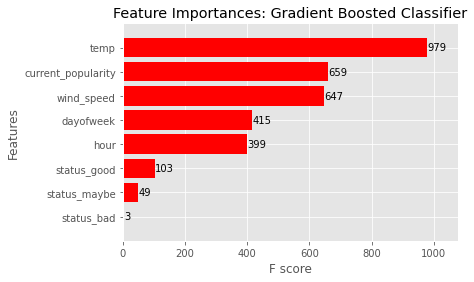

In [26]:
# Plot feature importance
from xgboost import plot_importance
plot_importance(clf.best_estimator_,height=0.8, color = 'red')
plt.title("Feature Importances: Gradient Boosted Classifier")
plt.savefig("../src/d06_visuals/modeling_xgb_feature_importances.png", bbox_inches = 'tight')
#plt.show()